In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import check_random_state
from scipy import interpolate

/Users/mburhanpurkar/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0-rc0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [21]:
def upsample(dim_new, arr):
    dim_old = np.shape(arr)[0]
    assert np.shape(arr)[0] == np.shape(arr)[1]
    x = np.arange(dim_old)
    f = interpolate.interp2d(x, x, arr, kind='linear')
    xnew = np.linspace(0, dim_old, dim_new)
    ynew = np.linspace(0, dim_old, dim_new)
    return f(xnew, ynew)

def show_digits(X, y, i):
    fig, ax = plt.subplots(1, len(i), sharex=True)
    for k, j in enumerate(i):
        ax[k].imshow(X[j])
        ax[k].set_title(y[j])
        ax[k].axis('off')
    plt.tight_layout()
    plt.show()
    
def mse(x, y):
    return np.mean((x - y)**2)

def mae(x, y):
    return np.mean(np.abs(x - y))

# Redo the Last Test Except with Larger Models!
In the last experiment, we used LeNet-5, which is known to actually be reasonably well-calibrated! To get more pronounced results, we need to use larger/deeper networks. Let's start off by trying a relatively simple ResNet.

First, we need to upsample the inputs...

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(np.shape(X), np.shape(y))

y = list(map(int, y))
y = list(map(lambda x: x > 4, y))
y = list(map(int, y))
y = np.array(y)

n_train = 6500
n_valid = 500
n_test = len(X) - n_train - n_valid

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_valid_tmp, y_train, y_valid_tmp = train_test_split(
    X, y, train_size=n_train)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_tmp, y_valid_tmp, train_size=n_valid)

print(np.shape(X_train), np.shape(X_valid), np.shape(X_test))
print(np.shape(y_train), np.shape(y_valid), np.shape(y_test))

scaler = StandardScaler() # MinMaxScaler() performs worse
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

(70000, 784) (70000,)
(6500, 784) (500, 784) (63000, 784)
(6500,) (500,) (63000,)


Then, we need to re-classify with the logistic regressor...

Test score: 0.8440


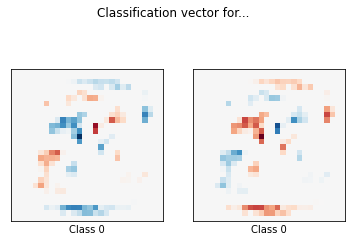

In [4]:
clf = LogisticRegression(solver='saga', penalty='l1', C=50. / n_train, tol=0.01, max_iter=10000)
clf.fit(X_train, y_train)

sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_valid, y_valid)
print("Test score: %.4f" % score)

coef = clf.coef_.copy()
scale = np.abs(coef).max()
fig, ax = plt.subplots(1, 2, sharex=True)
ax[0].imshow(coef.reshape(28, 28), interpolation='nearest',
               cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
ax[1].imshow((coef * -1).reshape(28, 28), interpolation='nearest',
               cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_xlabel('Class 0')
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_xlabel('Class 0')
plt.suptitle('Classification vector for...')
plt.show()

Generate train/valid/test...

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_test, y_test, train_size=55000)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, train_size=3000)
print(np.shape(X_train), np.shape(X_valid), np.shape(X_test))
print(np.shape(y_train), np.shape(y_valid), np.shape(y_test))

p_star_train = clf.predict_proba(X_train)[:, 1]
p_star_valid = clf.predict_proba(X_valid)[:, 1]
p_star_test = clf.predict_proba(X_test)[:, 1]

X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_valid = np.reshape(X_valid, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))
print(np.shape(X_train), np.shape(X_valid), np.shape(X_test))

y_train = np.random.binomial(1, p_star_train)
y_valid = np.random.binomial(1, p_star_valid)
y_test = np.random.binomial(1, p_star_test)

(55000, 784) (3000, 784) (5000, 784)
(55000,) (3000,) (5000,)
(55000, 28, 28, 1) (3000, 28, 28, 1) (5000, 28, 28, 1)


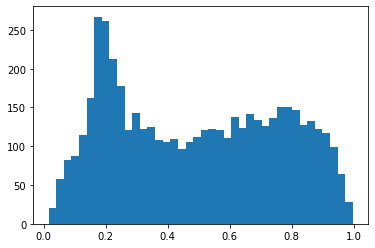

In [6]:
plt.hist(p_star_test, bins=40)
plt.show()

Upsample the x values

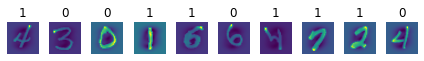

In [7]:
X_train_new = np.empty((len(X_train), 32, 32, 1))
for i, img in enumerate(X_train):
    X_train_new[i] = upsample(32, img).reshape(32, 32, 1)
    
X_valid_new = np.empty((len(X_valid), 32, 32, 1))
for i, img in enumerate(X_valid):
    X_valid_new[i] = upsample(32, img).reshape(32, 32, 1)
    
X_test_new = np.empty((len(X_test), 32, 32, 1))
for i, img in enumerate(X_test):
    X_test_new[i] = upsample(32, img).reshape(32, 32, 1)
    
show_digits(X_train_new, y_train, range(10))

In [12]:
X_train = X_train_new
X_valid = X_valid_new
X_test = X_test_new

# Train ResNet

In [79]:
small_resnet = tf.keras.applications.ResNet101V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top2 = keras.models.Sequential([
    keras.layers.Dense(256, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(128, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
], name='w_new')

top1 = keras.models.Sequential([
    keras.layers.Dense(256, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(128, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
], name='w_hat')


def schedule(epoch, lr):
    return lr / 1.5
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05),
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()

ftilde_model = keras.Sequential()
ftilde_model.add(small_resnet)
ftilde_model.add(top2)
ftilde_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss=keras.losses.BinaryCrossentropy(),
                     metrics=[keras.metrics.MeanSquaredError(), 
                              keras.metrics.BinaryAccuracy()])
ftilde_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 2048)              42620288  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 43,177,857
Trainable params: 43,080,193
Non-trainable params: 97,664
_________________________________________________________________
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 2048)              42620288  
_________________________________________________________________
w_new (Sequential)           (None, 1)                 557569    
Total params: 43,177,857
Trainable params: 43,080,193
Non-trainable params: 97,664
______________________________________________________________

In [80]:
hist = fhat_model.fit(x=X_train, y=y_train, epochs=50, batch_size=256, 
                      validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.033333333830038704.
215/215 [==============================] - 237s 1s/step - loss: 0.8106 - mean_squared_error: 0.2872 - binary_accuracy: 0.4984 - val_loss: 0.6935 - val_mean_squared_error: 0.2502 - val_binary_accuracy: 0.5197
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.022222223381201427.
215/215 [==============================] - 226s 1s/step - loss: 0.6993 - mean_squared_error: 0.2530 - binary_accuracy: 0.5019 - val_loss: 0.6942 - val_mean_squared_error: 0.2505 - val_binary_accuracy: 0.5197
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.014814815173546473.
215/215 [==============================] - 227s 1s/step - loss: 0.6982 - mean_squared_error: 0.2525 - binary_accuracy: 0.5038 - val_loss: 0.6943 - val_mean_squared_error: 0.2506 - val_binary_accuracy: 0.4803
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0098765436559915

Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 5.866983201485709e-07.
215/215 [==============================] - 226s 1s/step - loss: 0.6929 - mean_squared_error: 0.2499 - binary_accuracy: 0.5109 - val_loss: 0.6925 - val_mean_squared_error: 0.2497 - val_binary_accuracy: 0.5197
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 3.9113221343238064e-07.
124/215 [================>.............] - ETA: 1:38 - loss: 0.6931 - mean_squared_error: 0.2500 - binary_accuracy: 0.5060

KeyboardInterrupt: 

In [81]:
small_resnet.trainable = False
ftilde_model.summary() 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 2048)              42620288  
_________________________________________________________________
w_new (Sequential)           (None, 1)                 557569    
Total params: 43,177,857
Trainable params: 557,569
Non-trainable params: 42,620,288
_________________________________________________________________


In [82]:
hist2 = ftilde_model.fit(x=X_train, y=p_star_train, epochs=50, batch_size=256, 
                         validation_data=(X_valid, p_star_valid), callbacks=[lr_scheduler]) 

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0006666666983316342.
215/215 [==============================] - 236s 1s/step - loss: 0.6936 - mean_squared_error: 0.0735 - binary_accuracy: 0.0000e+00 - val_loss: 0.6926 - val_mean_squared_error: 0.0731 - val_binary_accuracy: 0.0000e+00
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00044444447848945856.
215/215 [==============================] - 222s 1s/step - loss: 0.6930 - mean_squared_error: 0.0723 - binary_accuracy: 0.0000e+00 - val_loss: 0.6928 - val_mean_squared_error: 0.0732 - val_binary_accuracy: 0.0000e+00
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002962963189929724.
215/215 [==============================] - 225s 1s/step - loss: 0.6927 - mean_squared_error: 0.0724 - binary_accuracy: 0.0000e+00 - val_loss: 0.6930 - val_mean_squared_error: 0.0733 - val_binary_accuracy: 0.0000e+00
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learnin

215/215 [==============================] - 218s 1s/step - loss: 0.6876 - mean_squared_error: 0.0700 - binary_accuracy: 0.0000e+00 - val_loss: 0.6902 - val_mean_squared_error: 0.0719 - val_binary_accuracy: 0.0000e+00
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 1.173396550295062e-08.
215/215 [==============================] - 221s 1s/step - loss: 0.6877 - mean_squared_error: 0.0697 - binary_accuracy: 0.0000e+00 - val_loss: 0.6902 - val_mean_squared_error: 0.0719 - val_binary_accuracy: 0.0000e+00
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 7.822643866006729e-09.
215/215 [==============================] - 243s 1s/step - loss: 0.6877 - mean_squared_error: 0.0696 - binary_accuracy: 0.0000e+00 - val_loss: 0.6904 - val_mean_squared_error: 0.0720 - val_binary_accuracy: 0.0000e+00
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 5.2150959106711525e-09.
215/215 [==============================] - 222s 1s/step - lo

The model has started to overfit... I might need to start many threads and only continue with the best models

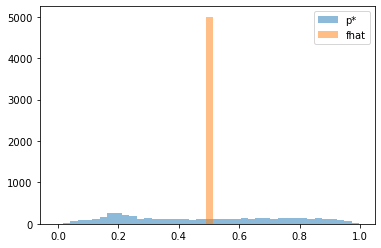

In [83]:
plt.hist(p_star_test, bins=40, label='p*', alpha=0.5)
plt.hist(fhat_model.predict(X_test), bins=40, label='fhat', alpha=0.5)
plt.legend()
plt.show()

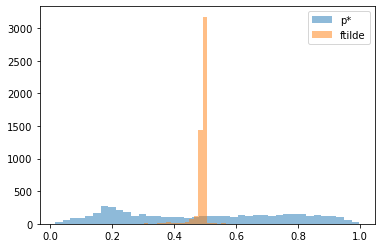

In [86]:
plt.hist(p_star_test, bins=40, label='p*', alpha=0.5)
plt.hist(ftilde_model.predict(X_test), bins=40, label='ftilde', alpha=0.5)
plt.legend()
plt.show()

In [87]:
xs = np.linspace(0, 1, 101)
preds = fhat_model.predict(X_test)
out_y = []
out_x = []
for i in range(len(xs) - 1):
    mask = np.logical_and(p_star_test > xs[i], p_star_test < xs[i + 1])
    out_y.append(np.mean(preds[mask]))
    out_x.append((xs[i] + xs[i + 1]) / 2.)

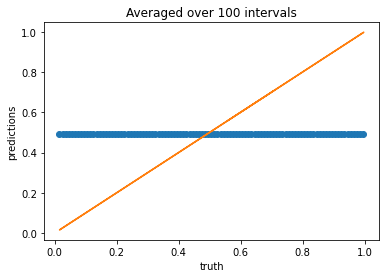

In [88]:
plt.plot(out_x, out_y, 'o')
plt.plot(p_star_test,p_star_test)
plt.xlabel("truth")
plt.ylabel("predictions")
plt.title("Averaged over 100 intervals")
plt.show()

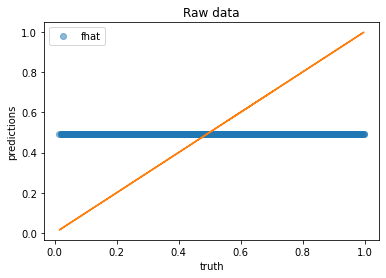

In [89]:
plt.plot(p_star_test, preds, 'o', alpha=0.5, label='fhat')
plt.plot(p_star_test,p_star_test)
plt.legend()
plt.xlabel("truth")
plt.ylabel("predictions")
plt.title("Raw data")
plt.show()

In [22]:
print(mse(p_star_test, small_resnet.predict(X_test)))
print(mae(p_star_test, small_resnet.predict(X_test)))

0.13372991008823298
0.297872670459621


What a disaster! Time to try some more serious training :)